## MIVA PhD Winter School 

Smooth and non-smooth optimisation for imaging applications: lab

Marta Lazzaretti: lazzaretti@dima.unige.it

In [1]:
import math 
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

## Forward model: blurring and downsampling operator

In SMLM type data, the acquisition consist of a blurred, undersampled  and noisy image of a molecule sample (the ground truth image). 
Let $x\in\mathbb R^{n^2}$ be the ground truth image. 

The microscope only allows us to have access to a blurred, undersampled and noisy version $$y=Ax+\eta,$$
where $A:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}, n=Ln,$ is the forward (blurring+undersampling) operator and $\eta\in\mathbb R^{m^2}$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$. 

$L>0$ is called super-resolution factor: the acquisition $y\in\mathbb R^{m^2}$ lives in a $L^2$ coarser grid than the ground truth $x\in\mathbb R^{n^2}$. 

Given the acquisition $y\in\mathbb R^{m^2}$, we aim at reconstructing the ground truth $x\in\mathbb R^{n^2}$. To do so, we need to know how to model the forward operator $A$ (that is we need to know how our microscope works). 

The forward operator can be modeled as $A=\tilde{M_L}*H$ where 

1) $H:\mathbb R^{n^2} \longrightarrow \mathbb R^{n^2}$ is the blurring operator and can be implemented as a convolution with the PSF 
2) $\tilde{M_L}:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}$ is the undersampling operator which takes an image in the finer grid and maps it in an image in the coarser grid, averaging the values on $L\times L$ patches of pixels.

 

Generate a ground truth image of dimensions $n\times n$, with a fixed number of molecules $N_{mol}$, placed at random in the sample. For simplicity, we choose not to place them too close to the border and stay $margin$ pixels away from it. 

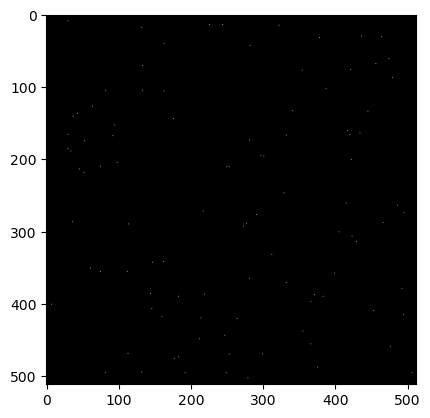

In [2]:
# in this way you will have a deterministic result
random.seed(17)

# ground truth image 
n = 512 # size of the image
gt = np.zeros([n,n])
N_mol = 100 # choose the number of molecules
margin = 5 # choose the empty margin
for k in np.arange(N_mol):
    i = random.randint(margin, n-margin)
    j = random.randint(margin, n-margin)
    gt[i,j] = 255
    
# plot the image
plt.imshow(gt,cmap='gray') 
plt.show()

Implementation of the forward operator. We start with the blurring operator $H\in\mathbb{R}^{n^2\times n^2}$.

We do not construct the blurring operator $H$ directly. We use the convolution with the PSF $h\in\mathbb{R}^{n^2}$ so that 
$$Hx=real(ifft2(fft2(h)*fft2(x))) \qquad \text{(pointwise multiplication!)}$$ 

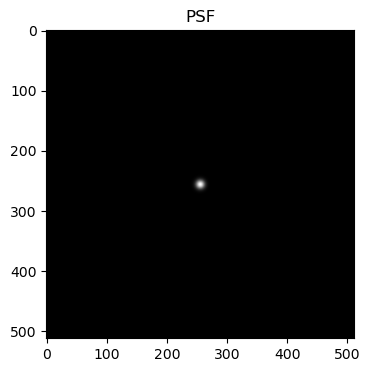

In [3]:
# convolution kernel: the point spread function PSF
s = 5 # choose a value that seems reasonable
n = np.shape(gt)[0]; 
x = np.concatenate( (np.arange(0,n/2), np.arange(-n/2,0)) )
[Y, X] = np.meshgrid(x, x)
h = np.exp((-X**2-Y**2)/ (2*s**2))
h = h/np.sum(h)

#plot the PSF
plt.figure(figsize=(4,4))
plt.imshow(np.fft.fftshift(h),cmap='gray') 
plt.title('PSF')
plt.show()

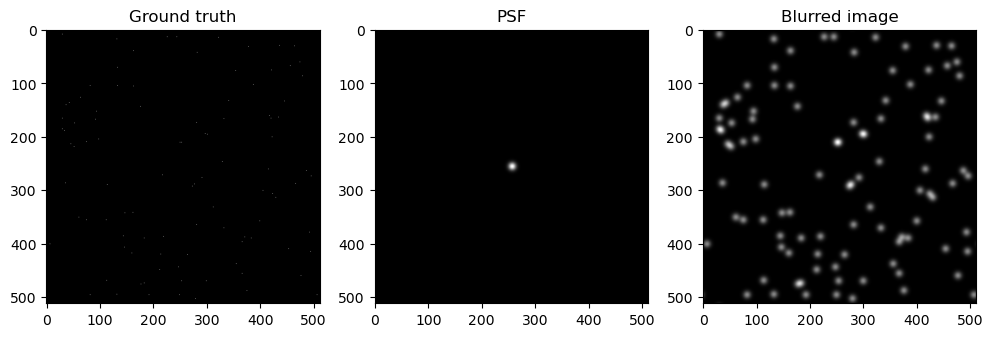

In [4]:
# define the blur operator 
def blur(x,h): 
    return np.real(np.fft.ifft2( np.fft.fft2(h) * np.fft.fft2(x) ))

blurred_image = blur(gt,h)

plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(gt,cmap='gray') 
plt.title('Ground truth')
plt.subplot(1,3,2)
plt.imshow(np.fft.fftshift(h),cmap='gray') 
plt.title('PSF')
plt.subplot(1,3,3)
plt.imshow(blurred_image,cmap='gray') 
plt.title('Blurred image')
plt.show()

Now we implement the downsampling matrix.

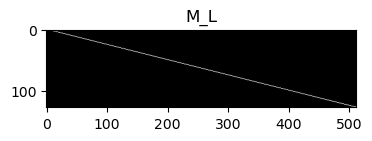

In [5]:
# super-resolution factor 
L = 4
m = int(n/L)
M_L = np.zeros([m,n])
for i in np.arange(m):
    M_L[i,L*i:L*i+L] = 1

# plot the downsampling matrix
plt.figure(figsize=(4,4))
plt.imshow(M_L,cmap='gray') 
plt.title('M_L')
plt.show()

To obtain the final blurred and downsampled image, which is a $m\times m$ image, we can still use the $n\times m$ matrix $M_L^t$: $M_L^t:\mathbb{R}^{m \times n}\longrightarrow\mathbb{R}^{m \times n}$ maps $m\times n$ images into $m\times m$ images summing vertically blocks of $L$ neighbour pixels. In this way, we obtain a $m\times m$ image whose pixels are the results of the sum of a neighbourhood of $L\times L$ pixels in the original (not downsampled) image.


As we do not construct the blurring operator $H$ directly, we do not construct the downsampling operator $M_L$ directly either. 
For $\tilde{M_L}\in\mathbb{R}^{n^2\times m^2}$, we DO NOT go to the Fourier domain! Recalling the computations above and given $M_L\in\mathbb{R}^{n^2\times mn}$, we can see that 
$$\tilde{M_L}z=M_L z M_L^t \qquad \text{(matrix multiplication!)}$$
Alltogether, this gives the forward operator: 
$$Ax=\tilde{M_L} H x = M_L(Hx) M_L^t = M_L \cdot real(ifft2(fft2(h)*fft2(x))) \cdot M_L^t$$

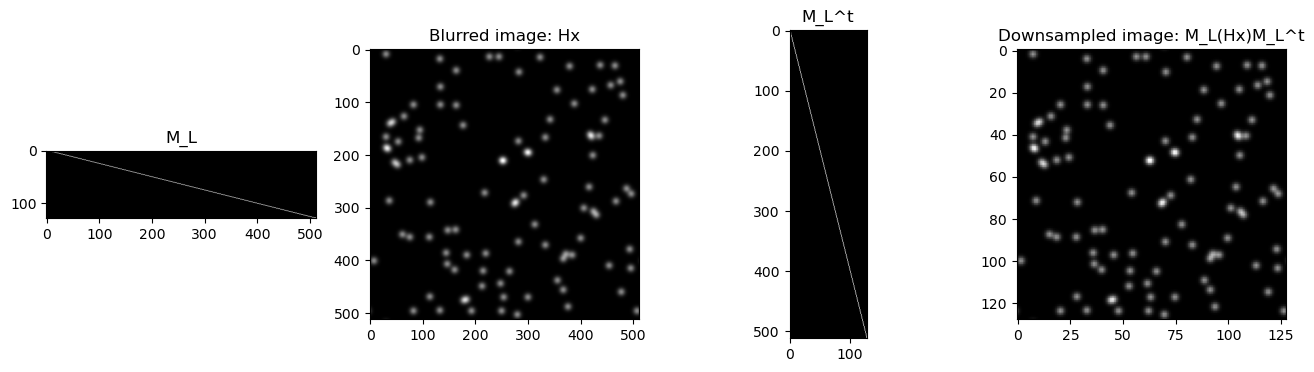

In [6]:
# define the downsampling and forward operator 
def down_sampling(x,M_L):
    return M_L@x@np.transpose(M_L)
def forward(x,h,M_L):
    return down_sampling(blur(x,h),M_L)

downsampled_image = forward(gt,h,M_L)

plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.imshow(M_L,cmap='gray') 
plt.title('M_L')
plt.subplot(1,4,2)
plt.imshow(blurred_image,cmap='gray') 
plt.title('Blurred image: Hx')
plt.subplot(1,4,3)
plt.imshow(np.transpose(M_L),cmap='gray') 
plt.title('M_L^t')
plt.subplot(1,4,4)
plt.imshow(downsampled_image,cmap='gray')
plt.title('Downsampled image: M_L(Hx)M_L^t')
plt.show()

Generate gaussian noise and add it to the blurred and downsampled image.

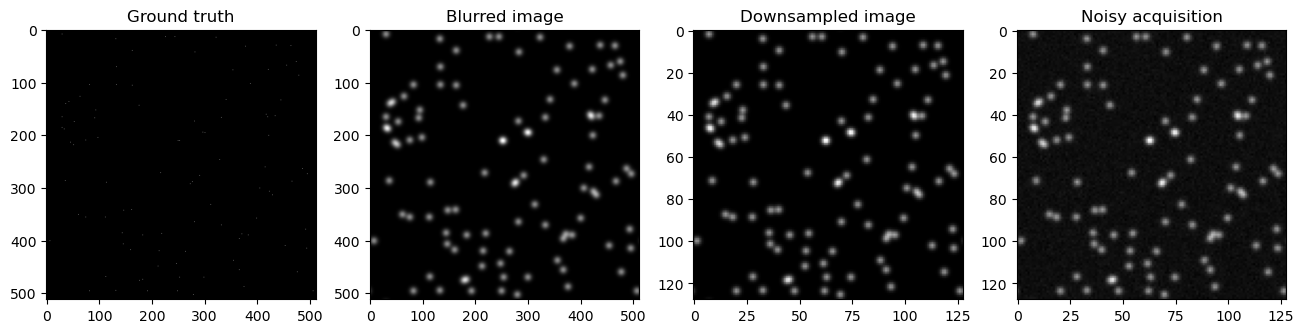

In [7]:
# in this way you will have a deterministic result
np.random.seed(24)
# generate gaussian noise 
sigma_noise = 0.7
noise = sigma_noise*np.random.randn(m,m)
# add gaussian noise to the blurred image
acq = downsampled_image + noise

plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.imshow(gt,cmap='gray') 
plt.title('Ground truth')
plt.subplot(1,4,2)
plt.imshow(blurred_image,cmap='gray') 
plt.title('Blurred image')
plt.subplot(1,4,3)
plt.imshow(downsampled_image,cmap='gray') 
plt.title('Downsampled image')
plt.subplot(1,4,4)
plt.imshow(acq,cmap='gray') 
plt.title('Noisy acquisition')
plt.show()

## Variational approach to the resolution of the inverse problem

Let $y\in\mathbb R^{m^2}$ be a noisy acquisition and $A:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}$ the forward operator. To solve the inverse problem i.e. to find $x\in\mathbb R^{n^2}$ such that $$y=Ax+\eta,$$ we use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^{n^2}} \frac{1}{2}\|Ax-y\|_2^2+\lambda R(x) +\texttt{i}_{\ge 0}(x) $$
where $R(x)$ is the regulariser or penalty term. How can we choose it? Which kind of solutions are we looking for? 

We need a regulariser which enforces sparsity in the reconstrictions: we want to find images of molecules where only a few pixels are non-zero. 

To do so, we can consider the $\ell_0$ pseudo-norm 
$$ \|x\|_0 = \#\{i=1,\cdot,n^2|\ x_i\not=0\}=\sum_{i=1}^{n^2} |x_i|_0 \text{ and }|u|_{0}= \begin{cases}0 & \text { if } u=0 \\ 1 & \text { otherwise }\end{cases}$$
which however is non-convex. 

To deal with convex sparsity penalty, we will consider the $\ell_1$ norm and solve the resulting optimisation problem with ISTA.

## Implementation of the Forward-Backward algorithm (ISTA)

$$ \operatorname{argmin}_{x\in\mathbb R^n} F(x):=\frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1+\texttt{i}_{\ge 0}(x) $$

Recall: the fidelity term is $f(x)=\frac{1}{2}\|Ax-y\|_2^2$ and its gradient is given by $\nabla f(x) = A^t(Ax-y)$. 

Now, the forward operator is $A:\mathbb{R}^{n^2}\longrightarrow\mathbb{R}^{m^2}$ with $A=\tilde{M_L} H$. 
Thus, $A^t=H^t \tilde{M_L}^t$ and 

$$A^t z = H^t \tilde{M_L}^t z = H^t \cdot (M_L^t z M_L) = real(\ ifft2(\ conj(fft2(h))\ *\ fft2(M_L^t z M_L) \ )\ )$$

In [8]:
# fidelity 
def fidelity(x,h,M_L,y):
    return 0.5*np.linalg.norm(forward(x,h,M_L)-y)**2

# gradient of the fidelity term 
def gradient(x,h,M_L,y):
    aus = np.transpose(M_L) @ (forward(x,h,M_L)-y) @ M_L
    return  np.real( np.fft.ifft2( np.conj(np.fft.fft2(h)) * np.fft.fft2(aus) ) ) 

# compute the Lipschitz constant Lips
hF = np.real(np.fft.fft2(np.fft.fftshift(h)))
Lips = np.max(hF**2)*L**2

Soft-thresholding of the $\|\cdot\|_1$ norm: proximal operator of the penalty

In [9]:
# prox of \ell_1 norm: soft thresholding function 
def soft_thresholding(x,gamma):
    return np.sign(x)*np.maximum(0,np.abs(x)-gamma)

Cost function:

In [10]:
# cost function 
def cost_function(x,h,M_L,y,lmbda):
    return fidelity(x,h,M_L,y)+lmbda*np.linalg.norm(x,1)

ISTA implementation

In [11]:
# input parameters
# x0 is the initialisation point
# tau is the stepsize
# lambda is the regolarisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def ISTA(x0,tau,lmbda,y,h,M_L,epsilon,maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        # forward step: gradient descent of f 
        xkk = xk - tau*gradient(xk,h,M_L,y)
        # backward step 
        xkk = soft_thresholding(xkk,tau*lmbda)
        # positivity constraints
        xkk = np.maximum(0,xkk)
        # compute the cost function
        cost[k] = cost_function(xkk,h,M_L,y,lmbda)
        norms[k] = np.linalg.norm(xkk-xk,'fro')
        # update the iteration
        xk = xkk
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

In [12]:
def plot_results(rec, cost, norms):
    # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gt, cmap='gray')
    plt.title('Ground truth')
    plt.subplot(1, 3, 2)
    plt.imshow(acq, cmap='gray')
    plt.title('Acquisition')
    plt.subplot(1, 3, 3)
    plt.imshow(rec, cmap='gray')
    plt.title('Reconstruction')
    plt.show()

    # plot cost function and relative differences in x_k
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(cost)
    plt.xlabel('$k$')
    plt.ylabel("$F(x_k)$")
    plt.title('Cost function')
    plt.subplot(1, 2, 2)
    plt.plot(norms)
    plt.xlabel('$k$')
    plt.ylabel("$||x^{(k+1)}-x_{k}||$")
    plt.title('Relative difference in the reconstructions')
    plt.show()

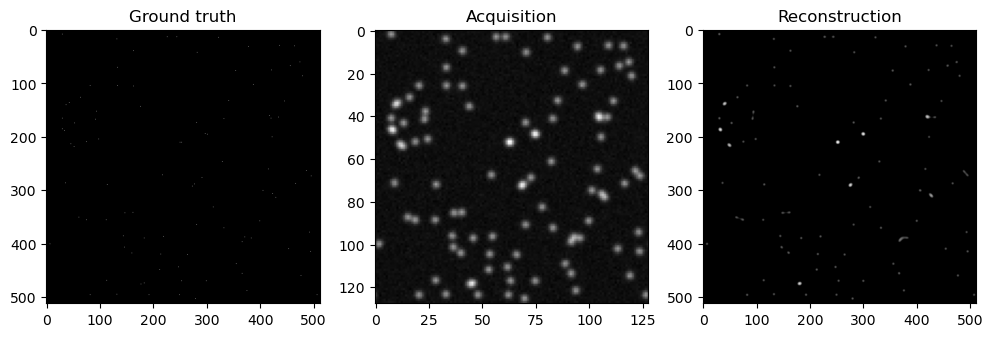

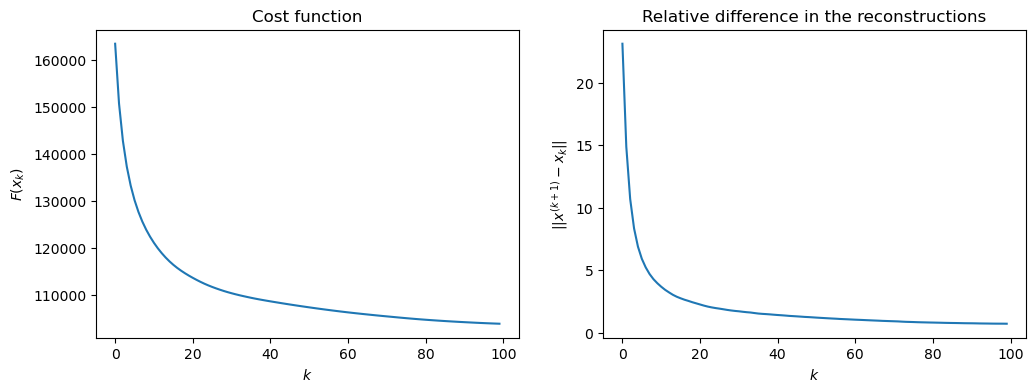

In [15]:
dim = (n,n)
x0 = np.zeros(dim)
tau = 0.9/Lips 
lmbda = 10
maxiter = 100
epsilon = 0.001

# compute the reconstruction
rec_ista, cost_ista, norms_ista = ISTA(x0,tau,lmbda,acq,h,M_L,0,maxiter)
plot_results(rec_ista, cost_ista, norms_ista)

## TO DO: implement FISTA

In [14]:
def FISTA(x0,tau,lmbda,y,h,M_L,epsilon,maxiter):
    xk = x0 
    xold = x0
    yk = x0
    told = 1
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        # update tk
        tk = 0.5*(1+math.sqrt(1+4*told**2))
        # inertia step
        yk = xk + (told-1)/tk*(xk-xold)
        # forward step: gradient descent of f 
        z = yk - tau*gradient(yk,h,M_L,y)
        # backward step 
        z = soft_thresholding(z,tau*lmbda)
        # positivity constraints
        z = np.maximum(0,z)
        # store the old iterations
        told = tk
        xold = xk
        xk =z        
        # compute the cost function
        cost[k] = cost_function(xk,h,M_L,y,lmbda)
        norms[k] = np.linalg.norm(xk-xold)
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

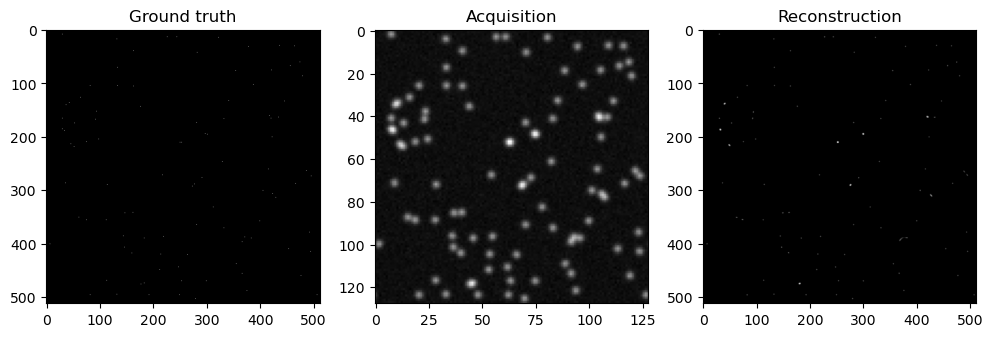

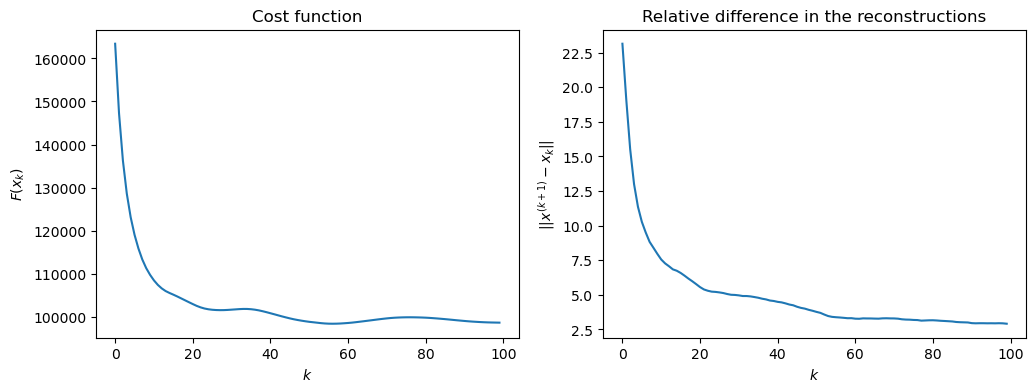

In [17]:
dim = (n,n)
x0 = np.zeros(dim)
tau = 0.9/Lips 
lmbda = 10
maxiter = 100
epsilon = 0.001

# compute the reconstruction
rec_fista, cost_fista, norms_fista = FISTA(x0,tau,lmbda,acq,h,M_L,0,maxiter)
plot_results(rec_fista, cost_fista, norms_fista)

## TO DO 

Compare the convergence rates $F(x_k)-F(x^*)$ along the first 500 iterations computed with ISTA VS FISTA algorithms.

Recall that: 
$$ F(x_k)-F(x^*) \leq \begin{cases} \mathcal{O}(1/k) & \text{ISTA}\\
\mathcal{O}(1/k^2) & \text{FISTA}
\end{cases}
$$

For $x^*$ use an approximation computed letting ISTA run for i.e. 2000 iterations.

In [ ]:
dim = (n,n)
x0 = np.zeros(dim)
tau = 0.9/Lips 
lmbda = 10
maxiter = 2000
epsilon = 0.001

# compute the reconstruction
rec, cost, norms = ISTA(x0,tau,lmbda,acq,h,M_L,0,maxiter)
plot_results(rec, cost, norms)

In [18]:
# save result for later
xstar = rec_ista
F_xstar = cost[maxiter-1]

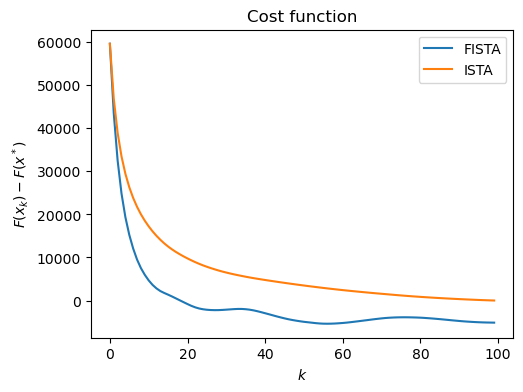

In [24]:
# compare the convergence rates
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cost_fista-F_xstar)
plt.plot(cost_ista-F_xstar)
plt.xlabel('$k$')
plt.ylabel("$F(x_k)-F(x^*)$")
plt.title('Cost function')
plt.legend(['FISTA', 'ISTA'])
plt.show()

## Strongly convex cost function

Now consider 

$$ \operatorname{argmin}_{x\in\mathbb R^n} F(x):=\frac{1}{2}\|Ax-y\|_2^2+\frac{\beta}{2}\|x\|_2^2+\lambda \|x\|_1+\texttt{i}_{\ge 0}(x) $$

## TO DO
1) Consider as fidelity $f(x):=\frac{1}{2}\|Ax-y\|_2^2+\frac{\beta}{2}\|x\|_2^2$, which is smooth, and compute the new Lipschitz constant and the new gradient.
Compute a reconstruction with FISTA in this case (be careful to change the gradient step and the cost function accordingly). The proximal step does not change.
2) Consider as fidelity $f(x):=\frac{1}{2}\|Ax-y\|_2^2$ and incorporate the new quadratic term in the regulariser $R(x)=\frac{\beta}{2}\|x\|_2^2+\lambda \|x\|_1$. In this case, the proximal step changes! 

Recall: Let $h(x):=\lambda g(x)+\frac{\beta}{2}\|x\|^2$, for $\lambda, \beta >0$. Then, for $\tau >0$:
$$
\operatorname{prox}_{\tau h}(x)=\operatorname{prox}_{\frac{\lambda \tau}{1+\beta \tau} g}\left(\frac{x}{1+\beta \tau}\right) \text {. }
$$

Compare the convergence rate in the two cases along 100 iterations. Be careful: you need to compute an approximation for $x^*$ again. 

1)

In [25]:
# l2 fidelity + quadratic perturbation: strongly convex
def SC_fidelity(x,h,M_L,y,beta):
    return 0.5*np.linalg.norm(forward(x,h,M_L)-y)**2+0.5*beta*np.linalg.norm(x)

# strongly convex cost function
def SC_cost_function(x,h,M_L,y,lmbda,beta):
    return SC_fidelity(x,h,M_L,y,beta)+lmbda*np.linalg.norm(x,1)

# Lipschitz constant
beta = 0.001
SC_Lips = Lips + beta

# gradient of the SC_fidelity
def SC_gradient(x,h,M_L,y,beta):
    aus = np.transpose(M_L) @ (forward(x,h,M_L)-y) @ M_L
    return  np.real( np.fft.ifft2( np.conj(np.fft.fft2(h)) * np.fft.fft2(aus) ) ) + beta*x

def SC1_FISTA(x0,tau,lmbda,beta,y,h,M_L,epsilon,maxiter):
    xk = x0 
    xold = x0
    yk = x0
    told = 1
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        # update tk
        tk = 0.5*(1+math.sqrt(1+4*told**2))
        # inertia step
        yk = xk + (told-1)/tk*(xk-xold)
        # forward step: gradient descent of f 
        z = yk - tau*SC_gradient(yk,h,M_L,y,beta)
        # backward step 
        z = soft_thresholding(z,tau*lmbda)
        # positivity constraints
        z = np.maximum(0,z)
        # store the old iterations
        told = tk
        xold = xk
        xk =z        
        # compute the cost function
        cost[k] = SC_cost_function(xk,h,M_L,y,lmbda,beta)
        norms[k] = np.linalg.norm(xk-xold)
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

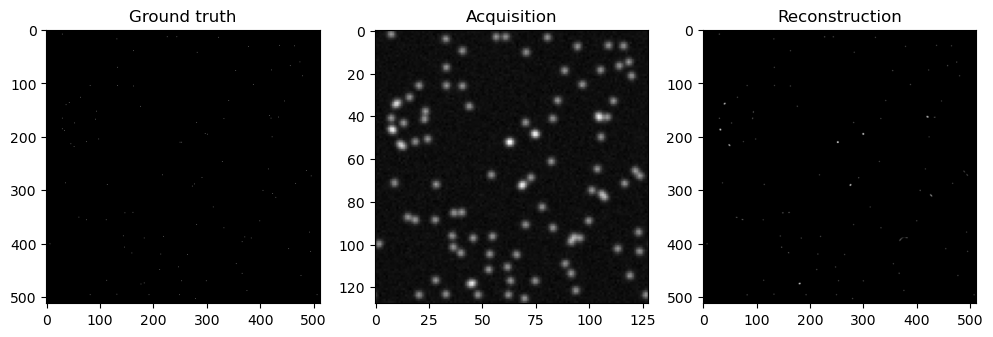

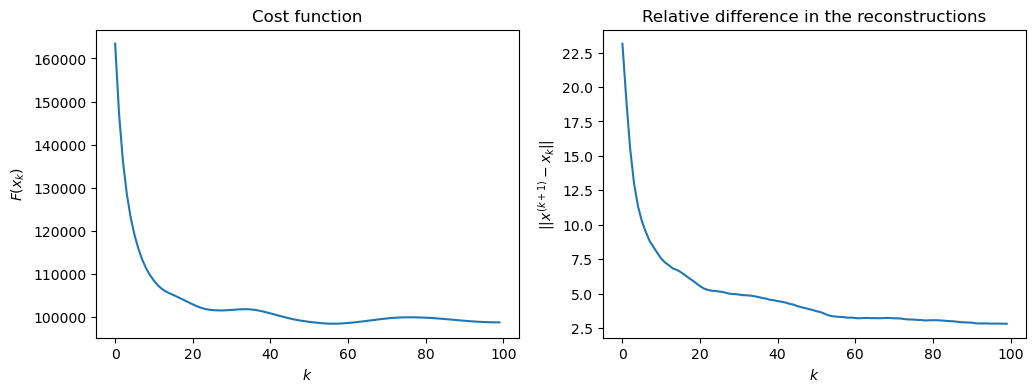

In [39]:
dim = (n,n)
x0 = np.zeros(dim)
tau = 0.9/SC_Lips 
lmbda = 10
maxiter = 100
epsilon = 0.001

# compute the reconstruction
rec_sc1_fista, cost_sc1_fista, norms_sc1_fista = SC1_FISTA(x0,tau,lmbda,beta,acq,h,M_L,0,maxiter)
plot_results(rec_sc1_fista, cost_sc1_fista, norms_sc1_fista)

2)

In [27]:
def SC2_FISTA(x0,tau,lmbda,beta,y,h,M_L,epsilon,maxiter):
    xk = x0 
    xold = x0
    yk = x0
    told = 1
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        # update tk
        tk = 0.5*(1+math.sqrt(1+4*told**2))
        # inertia step
        yk = xk + (told-1)/tk*(xk-xold)
        # forward step: gradient descent of f 
        z = yk - tau*gradient(yk,h,M_L,y)
        # backward step 
        z = soft_thresholding(z/(1+tau*beta),tau*lmbda/(1+tau*beta))
        # positivity constraints
        z = np.maximum(0,z)
        # store the old iterations
        told = tk
        xold = xk
        xk =z        
        # compute the cost function
        cost[k] = SC_cost_function(xk,h,M_L,y,lmbda,beta)
        norms[k] = np.linalg.norm(xk-xold)
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

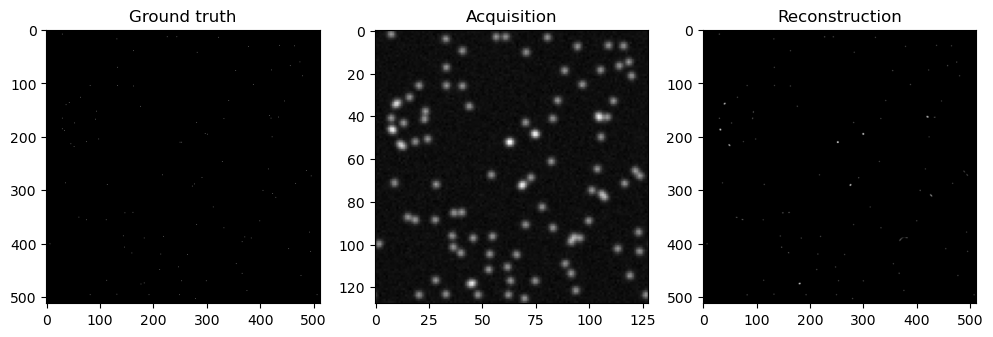

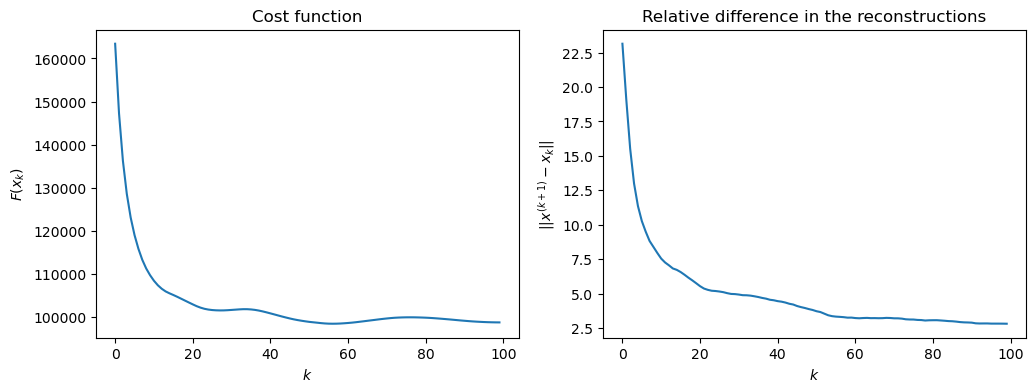

In [40]:
dim = (n,n)
x0 = np.zeros(dim)
tau = 0.9/SC_Lips 
lmbda = 10
maxiter = 100
epsilon = 0.001

# compute the reconstruction
rec_sc2_fista, cost_sc2_fista, norms_sc2_fista = SC2_FISTA(x0,tau,lmbda,beta,acq,h,M_L,0,maxiter)
plot_results(rec_sc2_fista, cost_sc2_fista, norms_sc2_fista)

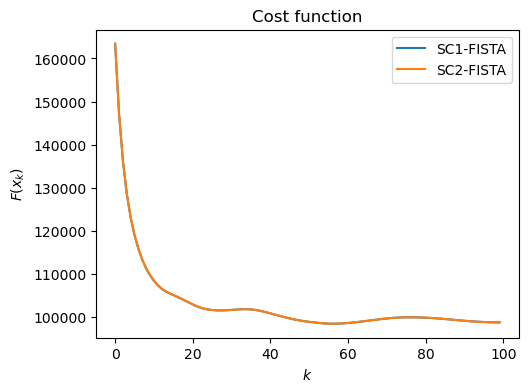

In [41]:
# compare the convergence rates
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cost_sc1_fista)
plt.plot(cost_sc2_fista)
plt.xlabel('$k$')
plt.ylabel("$F(x_k)$")
plt.title('Cost function')
plt.legend(['SC1-FISTA', 'SC2-FISTA'])
plt.show()

## TO DO: implement V-FISTA

In [37]:
def V_FISTA(x0,tau,lmbda,beta,y,h,M_L,epsilon,maxiter):
    L = 1/tau
    t = np.sqrt(L/beta)
    t = (t-1)/(t+1)
    xk = x0 
    xold = x0
    yk = x0
    told = 1
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):        
        # forward step: gradient descent of f 
        xk = yk - tau*SC_gradient(yk,h,M_L,y,beta)
        # backward step 
        xk = soft_thresholding(xk,tau*lmbda)
        # positivity constraints
        xk = np.maximum(0,xk)
        # inertia step
        yk = xk + t*(xk-xold)     
        # compute the cost function
        cost[k] = SC_cost_function(xk,h,M_L,y,lmbda,beta)
        norms[k] = np.linalg.norm(xk-xold)
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
        # store the old iteration
        xold = xk 
    return xk , cost, norms

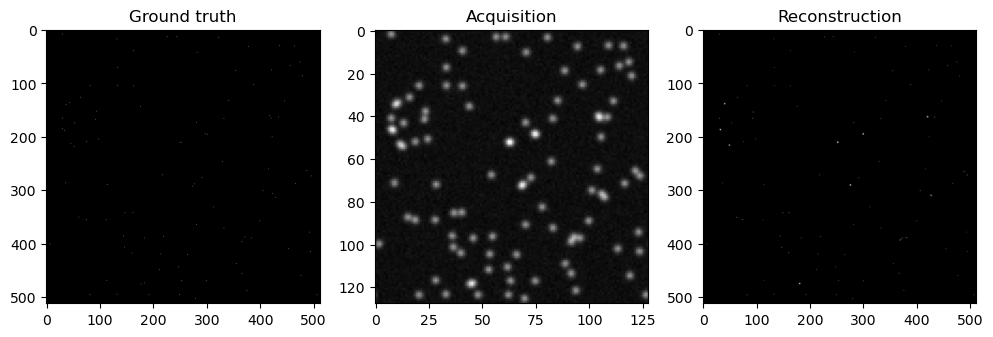

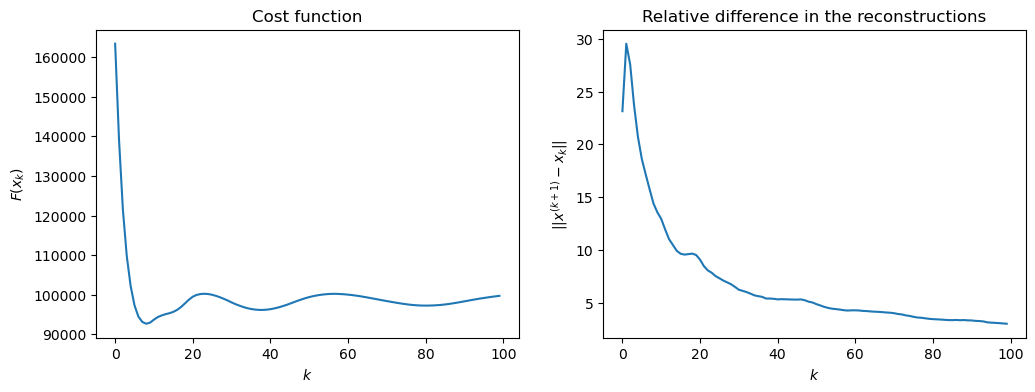

In [42]:
dim = (n,n)
x0 = np.zeros(dim)
tau = 0.9/SC_Lips 
lmbda = 10
maxiter = 100
epsilon = 0.001

# compute the reconstruction
rec_Vfista, cost_Vfista, norms_Vfista = V_FISTA(x0,tau,lmbda,beta,acq,h,M_L,0,maxiter)
plot_results(rec_Vfista, cost_Vfista, norms_Vfista)

Compare the convergence rates along the first 100 iterations computed with FISTA (in either of the two previous cases) and V-FISTA.

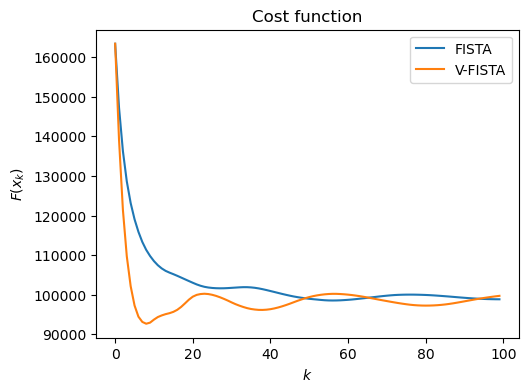

In [43]:
# compare the convergence rates
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cost_sc1_fista)
plt.plot(cost_Vfista)
plt.xlabel('$k$')
plt.ylabel("$F(x_k)$")
plt.title('Cost function')
plt.legend(['FISTA', 'V-FISTA'])
plt.show()